In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Introduction

In this notebook, I give a brief description and example of how time-series forecasting with ARIMA (autoregressive integrated moving average) works.

I'll begin by noting that applying linear regression models to time-series data often fails because it violates the assumption that the residuals are independent. If a linear regression model under predcits Monday's observation, it is also likely to underpredict Tuesday's observation. This issue can be checked by plotting the residuals over time:

Text(0.5, 1.0, 'Autocorrelated observations and residuals')

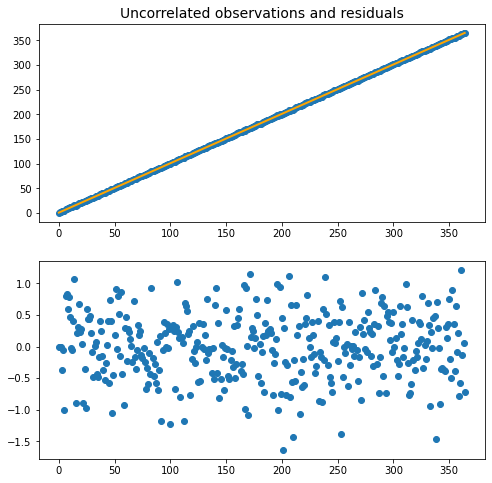

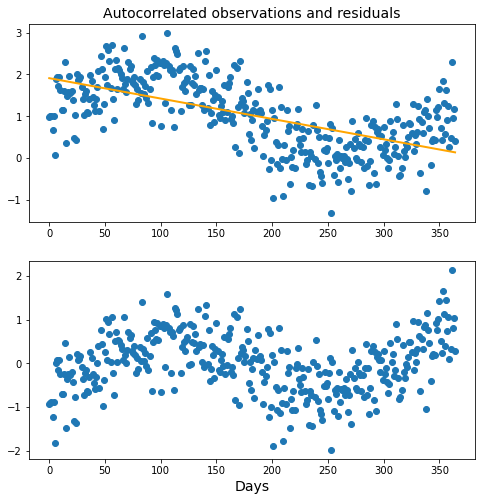

In [62]:
### Create some fake data that are uncorrelated over time

### X represents the days of the year (ignoring pesky leap-years)
n = 365
X = np.linspace(0, n, num=n, endpoint=False) 

b, m1 = 1, 1
e = np.random.normal(loc=0.0, scale=0.5, size=n)

Y_uncor = b + m1 * X + e
Y_cor = b + m1 * np.sin(np.radians(X)) + e ### represents some seasonal trend, like temperature

X = X[:, np.newaxis]
Y_uncor = Y_uncor[:, np.newaxis]
Y_cor = Y_cor[:, np.newaxis]

reg_uncor = LinearRegression().fit(X, Y_uncor)
reg_cor = LinearRegression().fit(X, Y_cor)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.scatter(X, Y_uncor)
ax1.plot(X, reg_uncor.predict(X), c='orange', lw=2)
ax1.set_title('Uncorrelated observations and residuals', fontsize=14)
ax2.scatter(X, Y_uncor - reg_uncor.predict(X))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.scatter(X, Y_cor)
ax1.plot(X, reg_cor.predict(X), color='orange', lw=2)
ax2.scatter(X, Y_cor - reg_cor.predict(X))
ax2.set_xlabel('Days', fontsize=14)
ax1.set_title('Autocorrelated observations and residuals', fontsize=14)

As we can see in this toy example, the residuals in the second set of data are not randomly distributed about zero and are correlated with one another. Contrast this with the first data set. 

The issue of autoregression in linear regression modeling is not insurmountable. One solution is to fit the observations to higher-order polynomials, e.g.: $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + ...$ A third-order polynomial would fit the above mock example very well and produce residuals centered randomly about zero. However, one problem, like for all linear regression models, is that \textit{extrapolating} outside the bounds of the predictors is ill-advised. Imagine we did fit a third-order polynomial to the previous example. For days greater than 365, the predicted model values would increase over time without bound. \textit{Forecasting} is not an issue in time-series modeling (to a point). A second issue is that the number of fit parameters has to increase. Our example has a trivial increase in fit parameters (2 to 4) in comparision to the number of observations. But, if the observed trend was weekly instead of seasonal, the fitted polynomial would have to be of large degree to capture the variation. 

### What is ARIMA?

#### AR

The goal of an \textit{autogressive} (AR) model is to fit an observation at time $t$ based on the observations at time $t-1, t-2, ... t-k$ where $k$ is known as the \textit{order}:

$y_t = \beta_0 + \beta_1 y_{t-1} + ... + \beta_k y_{t-k} + \epsilon_t$

The time intervals are assumed to be evenly spaced. 

But up to what order $k$ do we use? We'll explore this in the next section.

#### I

Time-series models often rely on \textit{differencing} or \textit{integrating} (I) in order to make transform the observations into \textit{stationary} ones. A stationary process is one whose properties are independent of the time at which the series is observed. Series with trends or seasonality are not stationary. Examples of non-stationary processes include the stock market and the global mean CO$_2$ concentration and temperature, plotted below.

Text(0, 0.5, 'Price')

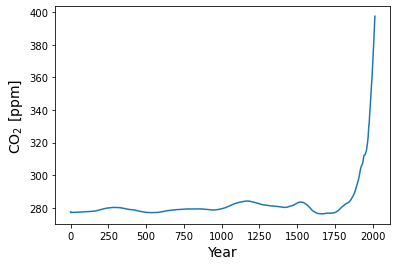

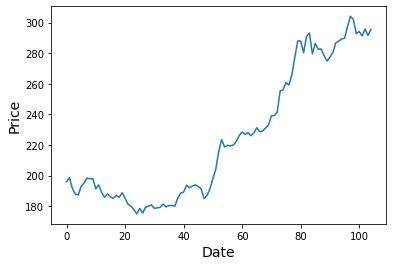

In [89]:
co2_file = './co2_concentration.csv'
stock_file = './google_stock.csv'

df_co2 = pd.read_csv(co2_file)
fig, ax = plt.subplots(1, 1)
ax.plot(df_co2['year'].values, df_co2['data_mean_global'].values)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('CO$_2$ [ppm]', fontsize=14)

df_stock = pd.read_csv(stock_file, sep='\t')
fig, ax = plt.subplots(1, 1)
ax.plot(df_stock['price'].values)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price', fontsize=14)

Differencing is done in order to ensure that the means and variances remain constant. The order of the difference is denoted as $d$. First-order differencing ($d=1$) is the change between consecutive observations:
    
$y'_t = y_t - y_{t-1}$

Second-order differences are the changes between consecutive first-order differences. Seasonal differencing is the change between observations by some set constant (e.g. 365 days if the changes are seasonal, e.g., Temperature data). Log transformations can also stabilize the variance. We look at how to test for stationary series and how to pick the right differencing in the next section. 

The first-order differences for the previous data are shown below. The stock price differences are roughly centered around 0 with constant variance. On the other hand, the differences in CO$_2$ concentration are not stable in recent years, indicating some other transformation must be done to properly model these data. 

Text(0, 0.5, 'Price Diff')

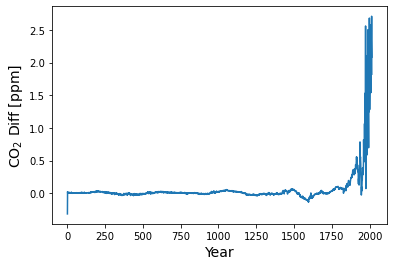

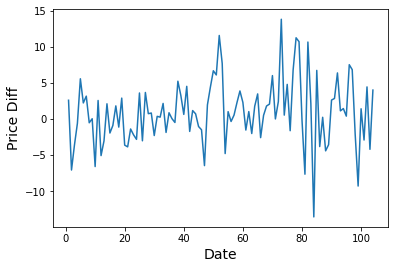

In [105]:
fig, ax = plt.subplots(1, 1)
ax.plot(df_co2['year'].values, df_co2['data_mean_global'].diff().values)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('CO$_2$ Diff [ppm]', fontsize=14)

fig, ax = plt.subplots(1, 1)
ax.plot(df_stock['price'].diff().values)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price Diff', fontsize=14)

#### MA

A moving average (MA) model uses the past forecast errors (instead of the observed data in AR) in regression:

$y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$,

where $q$ is the \textit{order}, analogous to the order $k$ in the AR model.  

The errors $\epsilon$ are assumed to be i.i.d sampled from a normal distribution with mean zero and constant variance. Since the errors are not observables, iterative non-linear methods are needed in place of the typical linear least squared. 

#### AR+I+MA

Combined, an ARIMA model is one which fits parameters $\beta$ and $\theta$ to data $y$ using the MLE:

$y_t = \beta_0 + \beta_1 y_{t-1} + ... + \beta_k y_{t-k} + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$

An ARIMA model with orders k, d, and q is denoted: ARIMA(k,d,q)

### Relevant Plots and Tests

How much differencing is required in an ARIMA model? What orders do we choose?

#### ACF and PACF

The autocorrelation function (ACF) describes the correlation between two values in a time series, e.g.:

$\text{CORR}(y_t, y_{t-k}), k=1,2,3...$

For stationary series, the ACF drops to zero quickly as the lag (value of $k$) increases. Further, the ACF at $k=1$ is usually large and positive for non-stationary data. This is because consecutive data in a non-stationary series usually retain 'memory' about the previous value (e.g., the value of a stock price on Friday is similar to its price on Thursday). This effect can overshadow other important lag terms. Differencing removes information about the absolute value of the series at any particular time and highlights other lag terms that contribute to the observed trends.

A partial autocorrelation function (PACF) is similar to the ACF except the contribution from the variables at times between $t$ and $t-k$ are removed. The PACF is useful for determining the order of an AR model, as the larger the PACF at a particular lag indicates lag terms that are useful predictors for $y_t$. Below we plot the ACF and PACF for both our sample data sets.

C:\Users\Josh\anaconda3\envs\game\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


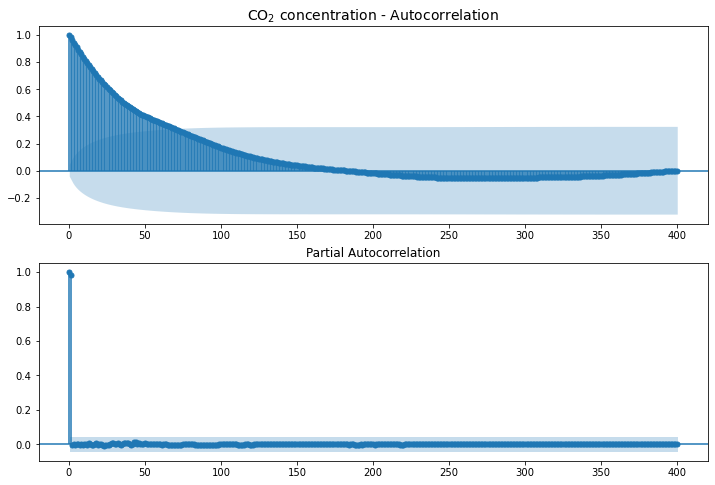

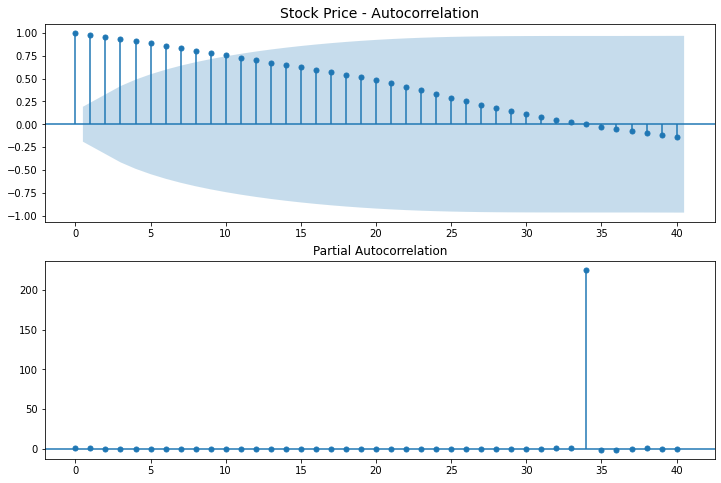

In [99]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_co2['data_mean_global'], lags=400, ax=ax1)
ax1.set_title('CO$_2$ concentration - Autocorrelation', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_co2['data_mean_global'], lags=400, ax=ax2)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_stock['price'], lags=40, ax=ax1)
ax1.set_title('Stock Price - Autocorrelation', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_stock['price'], lags=40, ax=ax2)

Points outside the blue region are important lag terms in terms of how correlated they are with $y_t$. In both cases, the ACF slowly decreases with increasing lag $k$, suggesting the data are non-stationary. In the CO$_2$ data, the PACF is highest for $k=0,1$ because the exponential rise in CO$_2$ concentration the past century means that the concentration next year strongly depends on what happens this year. In the stock data, the PACF peaks at $k=34$, which is the day the stock price began to rise. Since the price has been steadily rising since that date, the PACF recognizes that date as particularly important for explaining current trends. 

What happens if we use first-order differences?

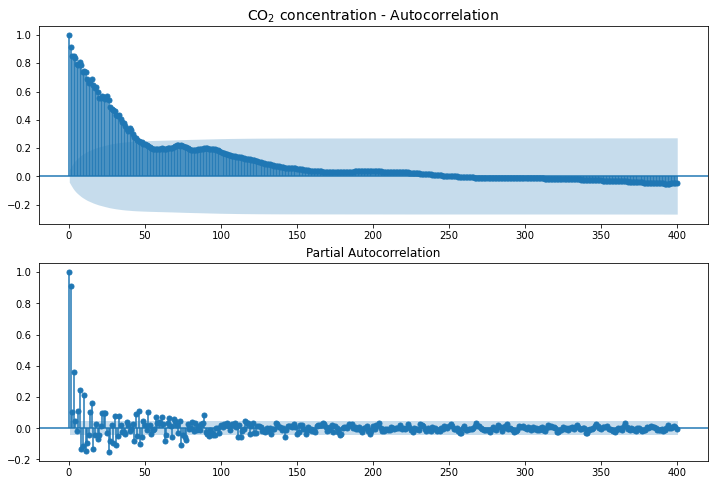

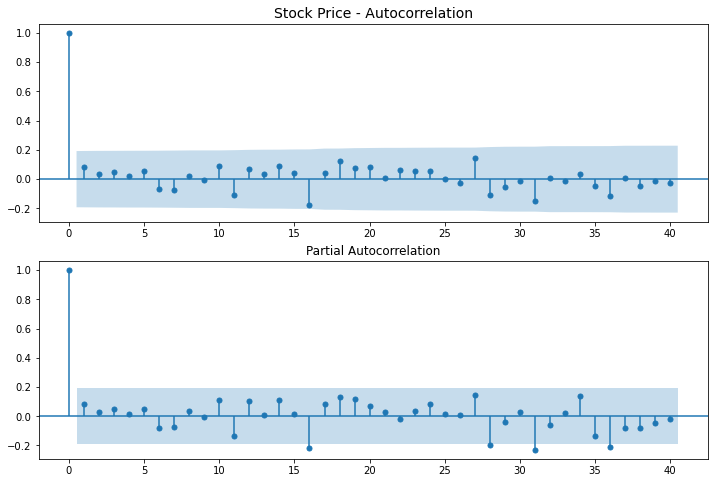

In [102]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_co2['data_mean_global'].diff().dropna(), lags=400, ax=ax1)
ax1.set_title('CO$_2$ concentration - Autocorrelation', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_co2['data_mean_global'].diff().dropna(), lags=400, ax=ax2)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_stock['price'].diff().dropna(), lags=40, ax=ax1)
ax1.set_title('Stock Price - Autocorrelation', fontsize=14)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_stock['price'].diff().dropna(), lags=40, ax=ax2)

For the CO$_2$ data, the ACF still peters out slowly with lags up to $\sim100$ years still significantly correlated. This makes sense given the first-order difference plots above, which are not centered around zero and do not have constant variance for the past 200 years. 

On the other hand, the stock market data show no lag is a significant predictor to the current value. Thus, the daily change in price is effectively a random variable uncorrelated to the change on any previous day. An ARIMA(0,1,0) model would be sufficient to model the daily change in stock price (i.e., it's a random walk). This is expressed as:

$y_t - y_{t-1} = \beta_0 + \epsilon_t\\$
$y_t = \beta_0 + y_{t-1} + \epsilon_t$

#### Unit Root Test for Differencing

The Augmented Dickey-Fuller test is one way of determining if a series is stationary (more technically, if there is a unit-root). The null hypothesis is that the data are non-stationary (there is a unit-root) while the alternative hypothesis is that they are stationary. We test this on our data below and see that first-order differencing is sufficient on the stock market data.

In [118]:
print('CO2 Concentration')
result = adfuller(df_co2['data_mean_global'])
print('Raw data...')
print('p-value of {:.2f}. Fail to reject the null hypothesis. The series is non-stationary'.format(result[1]))
result = adfuller(df_co2['data_mean_global'].diff().dropna())
print('Data are now differenced...')
print('p-value of {:.2f}. Fail to reject the null hypothesis. The series is non-stationary'.format(result[1]))
print('---------------')
print('Stock Market')
result = adfuller(df_stock['price'])
print('Raw data...')
print('p-value of {:.2f}. Fail to reject the null hypothesis. The series is non-stationary'.format(result[1]))
result = adfuller(df_stock['price'].diff().dropna())
print('Data are now differenced...')
print('p-value of {:.2f}. Reject the null hypothesis. The series is stationary'.format(result[1]))

CO2 Concentration
Raw data...
p-value of 1.00. Fail to reject the null hypothesis. The series is non-stationary
Data are now differenced...
p-value of 1.00. Fail to reject the null hypothesis. The series is non-stationary
---------------
Stock Market
Raw data...
p-value of 0.99. Fail to reject the null hypothesis. The series is non-stationary
Data are now differenced...
p-value of 0.00. Reject the null hypothesis. The series is stationary


#### Order Selection

What orders do we ultimately choose for our model? One way is using Akaike’s Information Criterion (AIC). As in normal regression, the AIC penalizes models that have low likelihood and many parameters. For an ARIMA(k,d,q) model, the AIC is defined as:

$\text{AIC} = -2\log L + 2(k + d + q + 1)$,

where $L$ is the likelihood.

Let's run an example ARIMA model and determine a lag order that does not add too much complexity.

Text(0, 0.5, 'AIC')

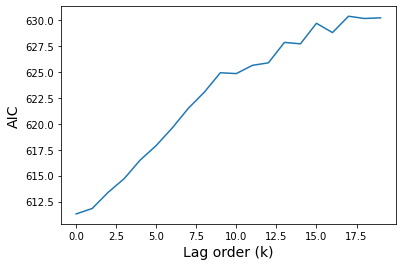

In [147]:
aic_list = []

for k in range(0,20):

    model = ARIMA(df_stock['price'], order=(k,1,0)) ### we dont call .diff() on the df as the order(d=1) takes care of differencing
    model_fit = model.fit()
    aic_list.append(model_fit.aic)
    
plt.plot(aic_list)
plt.xlabel('Lag order (k)', fontsize=14)
plt.ylabel('AIC', fontsize=14)

Thus, a lag order of 0 (where the AIC is minimized) is sufficient for modeling the stock price without adding unnecessary complexity, as predicted.

#### Residual tests

In order to validate our model, the residuals must be approximately normally distributed and that there is no evidence of autocorrelation.

A QQplot of the residuals and histogram of the residuals can gauge their normality:

AttributeError: 'list' object has no attribute 'shape'

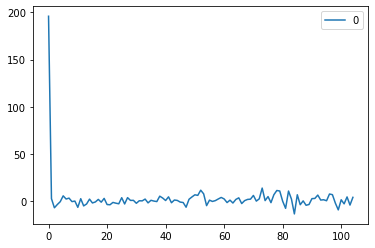

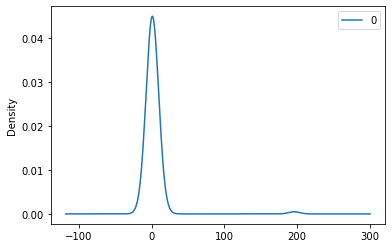

In [157]:
model = ARIMA(df_stock['price'], order=(0,1,0))
model_fit = model.fit()
residuals.plot()
residuals.plot(kind='kde')
sm.qqplot(sorte(residuals), line='45')

In [2]:
infile = './data/PM2.5_20160101_20161231.csv'

In [47]:
pm2p5 = pd.read_csv(infile, usecols=('date_local', 'latitude', 'longitude', 'arithmetic_mean'))
pm2p5.info()
pm2p5.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95526 entries, 0 to 95525
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_local       95526 non-null  object 
 1   latitude         95526 non-null  float64
 2   longitude        95526 non-null  float64
 3   arithmetic_mean  95526 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.9+ MB


,date_local,latitude,longitude,arithmetic_mean
0,2016-12-31,40.17093,-122.25556,13.1
1,2016-12-31,40.17093,-122.25556,13.1
2,2016-12-31,40.17093,-122.25556,13.1
3,2016-12-31,40.17093,-122.25556,13.1
4,2016-12-30,40.17093,-122.25556,7.6


In [49]:
### Files contain duplicates over the same time period, so drop them

pm2p5.drop_duplicates(inplace=True)
pm2p5.sort_values(by='date_local', ascending=True, inplace=True)
pm2p5.reset_index(drop=True, inplace=True)
pm2p5.head()

,date_local,latitude,longitude,arithmetic_mean
0,2016-01-01,34.942872,-120.435611,6.7
1,2016-01-01,34.276316,-118.683685,4.3
2,2016-01-01,36.819449,-119.716433,34.1
3,2016-01-01,37.793392,-121.247874,8.8
4,2016-01-01,37.743065,-122.169935,3.1


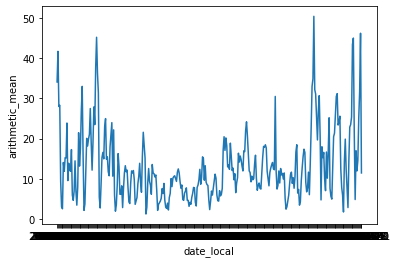

In [54]:
sns.lineplot(data = pm2p5.loc[pm2p5['latitude'] == 36.819449], x = 'date_local', y = 'arithmetic_mean')
plt.show()

In [52]:
pm2p5.loc[pm2p5['latitude'] == 36.819449]

,date_local,latitude,longitude,arithmetic_mean
2,2016-01-01,36.819449,-119.716433,34.1
109,2016-01-02,36.819449,-119.716433,41.7
148,2016-01-03,36.819449,-119.716433,28.0
200,2016-01-04,36.819449,-119.716433,28.3
285,2016-01-05,36.819449,-119.716433,9.4
...,...,...,...,...
23427,2016-12-27,36.819449,-119.716433,14.6
23544,2016-12-28,36.819449,-119.716433,25.1
23609,2016-12-29,36.819449,-119.716433,31.8
23662,2016-12-30,36.819449,-119.716433,46.2
